# Kaggle Bengali Handwritten Grapheme Classification

**Acknowledgements:**
1. [Competition](https://www.kaggle.com/c/bengaliai-cv19) on Kaggle.  
2. [Notebook](https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop) by Chris Deotte.  
3. [Video](https://www.youtube.com/watch?v=DEuvGh4ZwaY) on YouTube of the Accelerator Power Hour with Kaggle Grandmasters.  

**References:**
1. [EfficientNet](https://arxiv.org/abs/1905.11946) model.  
2. [Pretrained](https://github.com/lukemelas/EfficientNet-PyTorch) EfficientNet (PyTorch).  
3. [Pretrained](https://pypi.org/project/efficientnet/) EfficientNet (TensorFlow, Keras).  
4. [Parquet](https://parquet.apache.org/) _columnar storage_ format.  
5. [albumentations](https://albumentations.readthedocs.io/en/latest/) for fast image augmentation. ([Github repo](https://github.com/albumentations-team/albumentations))  
6. [CutMix](https://arxiv.org/abs/1905.04899) patch-based regularization strategy for images.  


**Table of contents:**
1. [Imports](#Imports)  
2. [Configure GPUs](#Configure-GPUs)  
3. [Enable mixed precision](#Enable-mixed-precision)  
4. [Set up logging](#Set-up-logging)  
5. [PIPELINE STEP 1: Preprocess](#PIPELINE-STEP-1:-Preprocess)  
   1. [Preprocess - EDA](#Preprocess---EDA)  
6. [PIPELINE STEP 2: Data augmentation](#PIPELINE-STEP-2:-Data-augmentation)  
   1. [Data augmentation - EDA](#Data-augmentation---EDA)  

## Imports

In [1]:
import time
startNB = time.time()   # Time the execution of the notebook

import tensorflow as tf, os
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score
import albumentations as albu, cv2, gc

print('TensorFlow version = {}'.format(tf.__version__))

/home/ivogeorg/anaconda3/envs/tf-22/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


TensorFlow version = 2.2.0


/home/ivogeorg/anaconda3/envs/tf-22/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Configure GPUs

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if len(gpus) == 1: 
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
else:
    strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


## Enable mixed precision

In [3]:
# tf.config.optimizer.set_jit(True)
tf.config.optimizer.set_experimental_options({'auto_mixed_precision': True})
print('Mixed precision enabled')  # When float32 needed, definte dtype explicitly

Mixed precision enabled


## Set up logging

In [4]:
# Logging directory
logging_dir = '../logging/'

# Logging version MAJOR and MINOR
mm = 1
rr = 0

# Begin log file
f = open(os.path.join(logging_dir, f'log-{mm}-{rr}.txt'), 'a')
print('Logging to {}'.format(f.name))

f.write('#############################\n')
f.write(f'Trial mm={mm}, rr={rr}\n')
f.write('efNetB4, batch_size=512, seed=42, 64x64, fold=0, LR 1e-3 with 0.75 decay\n')
f.write('#############################\n')
f.close()

# TODO: Consolidate hyperparameters
BATCH_SIZE = 512
DIM = 64

Logging to ../logging/log-1-0.txt


## PIPELINE STEP 1: Preprocess

Load image data and resize. For optimal GPU speed, do this once before the data loader instead of each time epoch in it. 

_Note: This notebook only uses 25% of the data._

In [12]:
data_dir = '../data/raw/'

In [7]:
%%time
train = []
# for x in [0, 1, 2, 3]:
for x in [0]:  # 25% of data
    f = 'train_image_data_%i.parquet' % x
    print(f, end='')
    img = pd.read_parquet(os.path.join(data_dir, f))  # pd df
    img = img.iloc[:, 1:].values.reshape((-1, 137, 236, 1))  # np array
    img2 = np.zeros((img.shape[0], DIM, DIM, 1), dtype='float32')
    for j in range(img.shape[0]):
        img2[j, :, :, 0] = cv2.resize(img[j,], 
                                      (DIM, DIM),
                                      interpolation=cv2.INTER_AREA)
        if j % 1000 == 0:
            print(j, ', ', end='')
    print()
    img2 = (255 - img2) / 255.  # normalize
    train.append(img2)

train_image_data_0.parquet0 , 1000 , 2000 , 3000 , 4000 , 5000 , 6000 , 7000 , 8000 , 9000 , 10000 , 11000 , 12000 , 13000 , 14000 , 15000 , 16000 , 17000 , 18000 , 19000 , 20000 , 21000 , 22000 , 23000 , 24000 , 25000 , 26000 , 27000 , 28000 , 29000 , 30000 , 31000 , 32000 , 33000 , 34000 , 35000 , 36000 , 37000 , 38000 , 39000 , 40000 , 41000 , 42000 , 43000 , 44000 , 45000 , 46000 , 47000 , 48000 , 49000 , 50000 , 
CPU times: user 35.2 s, sys: 8.28 s, total: 43.5 s
Wall time: 27.6 s


In [8]:
X_train = np.concatenate(train)
print('Train shape', X_train.shape)

Train shape (50210, 64, 64, 1)


In [9]:
del img, img2, train
_ = gc.collect()   # TODO: ?

### Preprocess - EDA

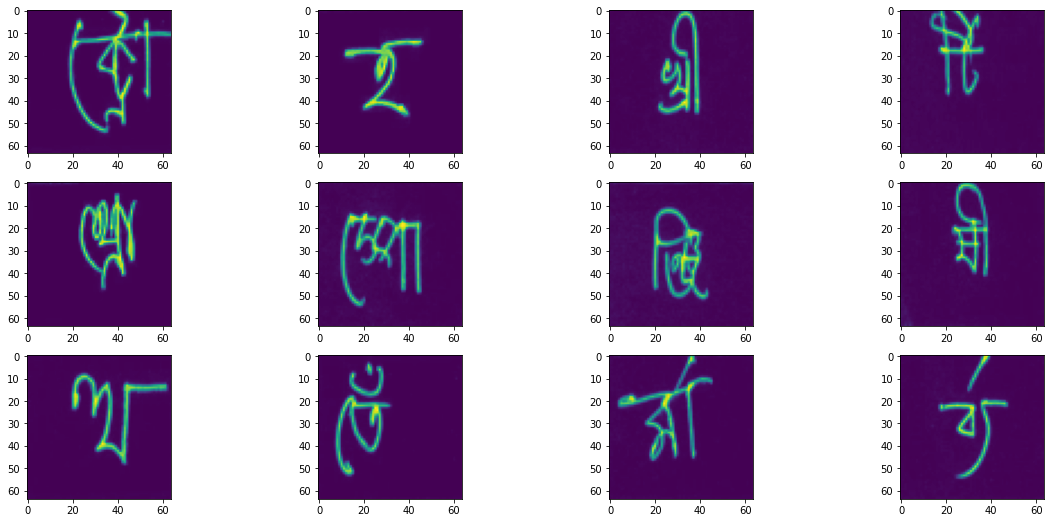

In [10]:
row = 3
col = 4
plt.figure(figsize=(20, (row / col) * 12))
for x in range(row * col):
    plt.subplot(row, col, x + 1)
    plt.imshow(X_train[x, :, :, 0])
plt.show()

In [13]:
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
y_train = train.iloc[:, 1:4].values[:len(X_train)]  # TODO: grok
print('Labels\nGrapheme Root, Vowel Diacritic, Consonant Diacritic')
y_train

Labels
Grapheme Root, Vowel Diacritic, Consonant Diacritic


array([[ 15,   9,   5],
       [159,   0,   0],
       [ 22,   3,   5],
       ...,
       [ 65,   9,   0],
       [ 24,   0,   0],
       [ 57,   1,   0]])

## PIPELINE STEP 2: Data augmentation

To optimize the data loader for GPU speed:
1. The time to process one batch on the CPU should be **less** the time to train one batch on the GPU.  
2. The batch size should be optimized to **maximize** GPU compute.  

In [19]:
class DataGenerator(tf.keras.utils.Sequence):  # TODO: Sequence
    'Generates data for Keras'
    def __init__(self, X, y, list_IDs, batch_size=BATCH_SIZE,
                 shuffle=False, augment=False, labels=True,
                 cutmix=False, yellow=False):
        self.X = X
        self.y = y
        self.augment = augment
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.labels = labels
        self.cutmix = cutmix
        self.yellow = yellow
        self.on_epoch_end()  # TODO: What does this do?
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.list_IDs) // self.batch_size
        ct += int((len(self.list_IDs) % self.batch_size) != 0)  # One batch if data left
        return ct
    
    def __getitem__(self, index):
        'Generates one batch of data'
        indexes = self.indexes[index * self.batch_size : 
                               (index + 1) * self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment:
            X = self.__augment_batch(X)
        if self.labels:
            return X, [y[:, 0:168], y[:, 168:179], y[:, 179:186]]  # TODO: Examine the data to see labels
        else:
            return X
        
    def on_epoch_end(self):
        'Updates indexes after each batch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)  # TODO: Grok indexes
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'
        X = self.X[self.list_IDs[indexes], ]
        if self.yellow:
            X = np.ones((len(indexes), DIM, DIM, 1))
        y = np.zeros((len(indexes), 186))
        for j in range(len(indexes)):
            y[j,       int(self.y[self.list_IDs[indexes[j]], 0])] = 1  # TODO: Grok
            y[j, 168 + int(self.y[self.list_IDs[indexes[j]], 1])] = 1
            y[j, 179 + int(self.y[self.list_IDs[indexes[j]], 2])] = 1

        if self.cutmix:
            for j in range(len(indexes)):
                
                # Choose random center
                yy = np.random.randint(0, DIM)
                xx = np.random.randint(0, DIM)
                z = np.random.choice(self.list_IDs)  # TODO: Grok
                
                # Choose random width and height
                h = np.random.randint(DIM // 2 - DIM // 16, DIM // 2 + DIM // 16)  # TODO: Grok
                w = np.random.randint(DIM // 2 - DIM // 16, DIM // 2 + DIM // 16)
                
                # Cut and mix images
                ya = max(0, yy - h // 2)
                yb = min(DIM, yy + h // 2)
                xa = max(0, xx - w // 2)
                xb = min(DIM, xx + w // 2)
                X[j, ya:yb, xa:xb, 0] = self.X[z, ya:yb, xa:xb, 0]
                
                # Cut and mix labels
                r = (yb - ya) * (xb - xa) / DIM / DIM   # TODO: Grok
                y2 = np.zeros((1, 186))
                y2[0,       int(self.y[z, 0])] = 1
                y2[0, 168 + int(self.y[z, 1])] = 1
                y2[0, 179 + int(self.y[z, 2])] = 1
                y[j, ] = (1 - r) * y[j, ] + r * y2[0, ]
                
        return X, y
    
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.OneOf([
                albu.ShiftScaleRotate(rotate_limit=8,
                                      scale_limit=0.16,
                                      shift_limit=0,
                                      border_mode=0,
                                      value=0,
                                      p=0.5),
                albu.CoarseDropout(max_holes=16,
                                   max_height=DIM//10,
                                   max_width=DIM//10,
                                   fill_value=0,
                                   p=0.5)
            ], p=0.5),
            albu.ShiftScaleRotate(rotate_limit=0,
                                  scale_limit=0.,
                                  shift_limit=0.12,
                                  border_mode=0,
                                  value=0,
                                  p=0.5)
        ])
        return composition(image=img)['image']  # TODO: Is this a signature?
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        return img_batch

### Data augmentation - EDA

*Cutmix* augmentation mixes two images together:
* The first image is displayed in yellow to visualize the augmentation. *This won't be done during training.*
* Rotation, scaling, shift, and coarse dropout can also be seen.  

Cutmix augmentation with first image in all yellow


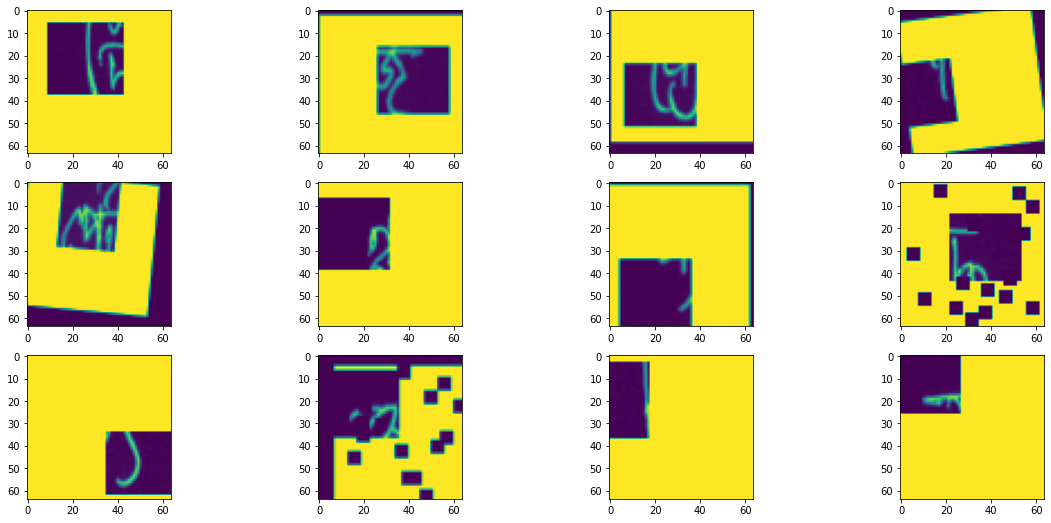

In [21]:
print('Cutmix augmentation with first image in all yellow')
gen = DataGenerator(X_train,
                    y_train,
                    np.arange(len(X_train)),
                    shuffle=True,
                    augment=True,
                    batch_size=BATCH_SIZE,
                    cutmix=True,
                    yellow=True)
row = 3
col = 4
plt.figure(figsize=(20, (row / col) * 12))
for batch in gen:
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.imshow(batch[0][j, :, :, 0])
    plt.show()
    break